### Célula 1: Configuração Inicial e Importações

Esta célula configura o ambiente do Jupyter Notebook, importando todas as bibliotecas Python necessárias para as tarefas de Processamento de Linguagem Natural (PLN), redes neurais e visualização.

In [ ]:
# Célula 1: Configuração Inicial e Importações
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Para a MLP
import torch
import torch.nn as nn
import torch.optim as optim

# Para embeddings multilíngues
from sentence_transformers import SentenceTransformer

# Para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Para manipulação de arquivos (necessário para Célula 2)
import re # Importar regex para a segmentação de texto na Célula 2

# Configurações para reprodutibilidade.
# Definir uma seed garante que resultados de processos aleatórios (como inicialização de pesos de rede neural) sejam os mesmos em execuções diferentes.
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available(): # Se houver GPU, também define a seed para CUDA
    print("Utilizando GPU!")
    torch.cuda.manual_seed_all(42)

print("Configurações iniciais e importações concluídas!")

Configurações iniciais e importações concluídas!


### Célula 2: Aquisição e Carregamento dos Dados

Esta célula é responsável por carregar o conteúdo dos três arquivos `.txt` fornecidos, que contêm o "Orlando Furioso" em sua versão original em italiano e duas traduções para o inglês. O objetivo principal é **segmentar cada obra de forma precisa, primeiro por canto e, dentro de cada canto, por estrofes numeradas sequencialmente a partir de 1**. Os dados são então organizados em um `DataFrame` estruturado para as análises subsequentes.

#### Detalhes:
* **Segmentação Precisa:** Utiliza **expressões regulares** para identificar os marcadores de `CANTO X` e os números das estrofes (`N\n`) que iniciam cada estrofe. Isso garante que a estrutura exata do poema (cantos e estrofes numeradas de 1 em diante) seja preservada.
* **Granularidade em nível de Estrofe:** A segmentação no nível da estrofe permite uma análise de fidelidade satisfatória, revelando nuances de tradução que seriam imperceptíveis em uma análise de canto inteiro ou de versos individuais.
* **Alinhamento de Conteúdo:** O processo tenta alinhar as estrofes entre as diferentes versões com base em seus números de canto e estrofe. Quaisquer estrofes ausentes em uma versão (mas presentes no original) serão marcadas adequadamente para garantir que a comparação seja feita apenas onde há conteúdo correspondente.
* **Estrutura do DataFrame:** O `DataFrame` resultante (`df_estrofes`) é a base para o pipeline, contendo colunas para o número do canto, o número da estrofe, e o texto de cada estrofe em cada uma das três versões da obra.

In [2]:
# Célula 2: Aquisição e Carregamento dos Dados

FILE_PATHS = {
    'italiano': 'Orlando Furioso - Ludovico Ariosto - Original.txt',
    'ingles_william': 'Orlando Furioso - Ludovico Ariosto - English from William Stewart Rose.txt',
    'ingles_john': 'Orlando Furioso - Ludovico Ariosto - English from John Harington.txt'
}

# Regex para identificar o início de um Canto.
# Captura a palavra "CANTO" seguida de um espaço, um ou mais dígitos (o número do canto), e uma quebra de linha.
# Ex: "CANTO 1\n", "CANTO 2\n"
CANTO_PATTERN = re.compile(r'CANTO\s+(\d+)\s*\n')

# Regex para identificar o início de uma estrofe dentro de um Canto.
# ^\s*(\d+)\s*\n: Captura um número de estrofe no início da linha (com espaços opcionais), seguido de uma quebra de linha.
# ((?:(?!^\s*\d+\s*\n|CANTO\s+\d+\s*\n).)*): Esta é uma lookahead negativa complexa.
#   (?: ... )* : Grupo não capturante, repetido zero ou mais vezes.
#   (?!^\s*\d+\s*\n|CANTO\s+\d+\s*\n) : Garante que a correspondência NÃO seja seguida por um novo número de estrofe ou um novo marcador de canto.
#   . : Captura qualquer caractere (incluindo quebras de linha devido a re.DOTALL).
# Isso permite que a estrofe contenha múltiplas linhas e quebras de linha internas, parando no início da próxima estrofe numerada ou do próximo canto.
STROFE_PATTERN = re.compile(r'^\s*(\d+)\s*\n((?:(?!^\s*\d+\s*\n|CANTO\s+\d+\s*\n).)*)', re.MULTILINE | re.DOTALL)


def extract_stanzas_from_text(text_content):
    """
    Extrai cantos e estrofes de um texto completo.
    Retorna um dicionário: {canto_num: {estrofe_num: texto_estrofe, ...}, ...}
    """
    cantos_data = {}
    
    # Adicionar um marcador de fim de texto para garantir que a última estrofe do último canto seja capturada.
    # Isso evita que o re.split ou re.finditer não capture o final do último segmento.
    text_content += "\nCANTO 9999\n" 
    
    # Dividir o texto pelos marcadores de CANTO.
    canto_splits = CANTO_PATTERN.split(text_content) 
    
    # O primeiro elemento de `canto_splits` (índice 0) é o texto antes do primeiro canto (título do livro, etc.).
    # O algoritmo itera a partir do índice 1, pulando de 2 em 2 para pegar o número do canto e o texto correspondente.
    for i in range(1, len(canto_splits), 2):
        try:
            canto_num_str = canto_splits[i] # O número do canto como string
            canto_text_content = canto_splits[i+1] # O conteúdo do canto (texto das estrofes)
            
            canto_num = int(canto_num_str) # Converte o número do canto para inteiro
            
            if canto_num == 9999: # Se chegamos ao marcador sentinela, paramos o processamento
                break
            
            estrofes_do_canto = {} # Dicionário para armazenar estrofes deste canto
            
            # Encontrar todas as estrofes dentro do texto deste canto usando `STROFE_PATTERN`.
            matches = list(STROFE_PATTERN.finditer(canto_text_content))
            
            if not matches:
                # Se não foram encontradas estrofes numeradas neste segmento de canto,
                # mas o texto do canto não é vazio, trata-o como uma única estrofe (estrofe 1).
                # Isso pode ser para introduções de canto que não são numeradas como estrofes poéticas.
                if canto_text_content.strip(): # Verifica se o texto do canto não é apenas espaços em branco
                    estrofes_do_canto[1] = canto_text_content.strip() # Armazena como estrofe número 1
            else:
                # Processa cada correspondência de estrofe encontrada
                for match in matches:
                    try:
                        estrofe_num = int(match.group(1)) # O primeiro grupo capturado é o número da estrofe
                        estrofe_text = match.group(2).strip() # O segundo grupo capturado é o texto da estrofe
                        if estrofe_text: # Adiciona a estrofe ao dicionário apenas se ela tiver conteúdo
                            estrofes_do_canto[estrofe_num] = estrofe_text
                    except ValueError:
                        # Em caso de erro na conversão do número da estrofe (ex: não é um número válido), ignora essa estrofe.
                        print(f"Aviso: Não foi possível converter número de estrofe '{match.group(1)}' no canto {canto_num}. Ignorando esta estrofe.")
                        pass
            
            if estrofes_do_canto: # Adiciona o canto ao dicionário principal apenas se ele tiver estrofes válidas
                cantos_data[canto_num] = estrofes_do_canto

        except (ValueError, IndexError) as e:
            # Captura erros se o `canto_splits` não contém os elementos esperados (ex: índice fora do limite)
            # ou se a conversão para inteiro falha. Imprime um aviso e pula o segmento problemático.
            print(f"Erro de parsing na estrutura de canto/estrofe: {e}. Pulo. Segmento problemático: {canto_splits[i:i+2]}")
            continue # Continua para o próximo par de elementos em `canto_splits`

    return cantos_data


all_stanzas_data = [] # Lista para armazenar os dados de todas as estrofes para o DataFrame final
max_canto_overall = 0 # Variável para rastrear o maior número de canto encontrado em todas as versões
max_estrofe_in_canto_all_versions = {} # Dicionário para rastrear o maior número de estrofe para cada canto, entre todas as versões.

# Iterar sobre cada versão do livro definida em `FILE_PATHS`
processed_books = {} # Dicionário para armazenar os dados processados de cada livro ('italiano', 'ingles_william', etc.)
for version_name, file_path in FILE_PATHS.items():
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            full_text = f.read() # Lê o conteúdo completo do arquivo
        print(f"Lendo e processando: {file_path}")
        processed_books[version_name] = extract_stanzas_from_text(full_text) # função para extrair cantos e estrofes
        
        # Atualiza `max_canto_overall` e `max_estrofe_in_canto_all_versions`
        for canto_num, stanzas in processed_books[version_name].items():
            if canto_num > max_canto_overall:
                max_canto_overall = canto_num
            for estrofe_num in stanzas.keys():
                if canto_num not in max_estrofe_in_canto_all_versions or estrofe_num > max_estrofe_in_canto_all_versions[canto_num]:
                    max_estrofe_in_canto_all_versions[canto_num] = estrofe_num

    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado em {file_path}. Verifique o nome e o caminho do arquivo.")
        exit() 
    except Exception as e:
        print(f"Erro inesperado ao processar o arquivo {file_path}: {str(e)}")
        exit()

# Construir o DataFrame final, garantindo alinhamento por canto e estrofe.
for canto_num in range(1, max_canto_overall + 1):
    # Itera sobre todas as estrofes possíveis dentro do canto atual (do 1 até a maior estrofe encontrada para esse canto).
    # `get(canto_num, 0)` retorna 0 se o canto não tiver estrofes, para que o `range` comece em 1 e não gere erros.
    for estrofe_num in range(1, max_estrofe_in_canto_all_versions.get(canto_num, 0) + 1):
        # Cria um dicionário para a linha atual do DataFrame
        row_data = {
            'canto': canto_num,
            'estrofe': estrofe_num,
            # Tenta obter o texto da estrofe para cada versão. Se a estrofe não existir (None), será tratado depois.
            'italiano': processed_books['italiano'].get(canto_num, {}).get(estrofe_num, None),
            'ingles_william': processed_books['ingles_william'].get(canto_num, {}).get(estrofe_num, None),
            'ingles_john': processed_books['ingles_john'].get(canto_num, {}).get(estrofe_num, None)
        }
        # Adiciona a linha ao `all_stanzas_data` apenas se houver pelo menos um texto válido para essa estrofe.
        # Isso evita adicionar linhas completamente vazias para estrofes que não existem em nenhuma versão.
        if any(v is not None for k, v in row_data.items() if k not in ['canto', 'estrofe']):
            all_stanzas_data.append(row_data)

df_estrofes = pd.DataFrame(all_stanzas_data) # Criação do DataFrame

# Filtrar linhas onde a estrofe original (italiano) está ausente (não é possível comparar traduções sem o texto original).
df_estrofes = df_estrofes.dropna(subset=['italiano']).reset_index(drop=True)

# Preencher quaisquer valores ausentes (Nones) nas colunas de tradução com strings vazias.
# Isso evita erros no pré-processamento e na geração de embeddings, que esperam strings.
df_estrofes['ingles_william'] = df_estrofes['ingles_william'].fillna('')
df_estrofes['ingles_john'] = df_estrofes['ingles_john'].fillna('')

print(f"\nDataFrame final criado com {len(df_estrofes)} estrofes para análise.")
print("Primeiras 10 estrofes do DataFrame:")
print(df_estrofes.head(10).to_string(index=False))

print("\nVerificação do número de estrofes em alguns cantos para cada versão (exemplos):")
print(f"Total de cantos únicos processados no DataFrame: {df_estrofes['canto'].nunique()}")
print(f"Número de estrofes no Canto 1 (Original Italiano - Ludovico): {len(processed_books['italiano'].get(1, {}))}")
print(f"Número de estrofes no Canto 1 (Inglês Tradução 1 - Willian): {len(processed_books['ingles_william'].get(1, {}))}")
print(f"Número de estrofes no Canto 1 (Inglês Tradução 2 - John): {len(processed_books['ingles_john'].get(1, {}))}")
print("\nAquisição e carregamento dos dados reais (por estrofe) concluídos!")

Lendo e processando: Orlando Furioso - Ludovico Ariosto - Original.txt
Lendo e processando: Orlando Furioso - Ludovico Ariosto - English from William Stewart Rose.txt
Lendo e processando: Orlando Furioso - Ludovico Ariosto - English from John Harington.txt

DataFrame final criado com 4842 estrofes para análise.
Primeiras 10 estrofes do DataFrame:
 canto  estrofe                                                                                                                                                                                                                                                                                                                            italiano                                                                                                                                                                                                                                                                                                                        

### Célula 3: Pré-processamento dos Textos

Esta célula prepara os textos das estrofes para a análise, com um **pré-processamento minimalista otimizado para a geração de embeddings**, garantindo que a informação contextual seja preservada.

#### Detalhes:
* **Preservação da Semântica para Embeddings:** Para modelos de `SentenceTransformers`, a prática ideal é fornecer o texto o mais próximo do original possível (apenas em minúsculas). Isso permite que o modelo pré-treinado utilize toda a informação contextual, incluindo pontuação, acentos e elisões (`l'arme`, `ch'io`), pois ele já foi treinado para entender essas nuances. A única transformação aplicada nesta etapa é a **conversão para minúsculas**, o que é um passo fundamental para a consistência sem afetar a integridade semântica.

In [ ]:
# Célula 3: Pré-processamento dos Textos

def preprocess_text_for_embeddings(text):
    """
    Pré-processa o texto para a geração de embeddings:
    """
    return text.lower()

# Aplicar o pré-processamento leve para embeddings a cada coluna de texto.
# As novas colunas '_processed' conterão o texto em minúsculas com sua formatação original.
df_estrofes['italiano_processed'] = df_estrofes['italiano'].apply(preprocess_text_for_embeddings)
df_estrofes['ingles_william_processed'] = df_estrofes['ingles_william'].apply(preprocess_text_for_embeddings)
df_estrofes['ingles_john_processed'] = df_estrofes['ingles_john'].apply(preprocess_text_for_embeddings)

print("\nEstrofes pré-processadas para embeddings (exemplo da primeira estrofe do Canto 1):")
print(f"Original Italiano:\n{df_estrofes.loc[(df_estrofes['canto'] == 1) & (df_estrofes['estrofe'] == 1), 'italiano_processed'].iloc[0][:200]}...")
print(f"Tradução 1 Inglês:\n{df_estrofes.loc[(df_estrofes['canto'] == 1) & (df_estrofes['estrofe'] == 1), 'ingles_william_processed'].iloc[0][:200]}...")
print(f"Tradução 2 Inglês:\n{df_estrofes.loc[(df_estrofes['canto'] == 1) & (df_estrofes['estrofe'] == 1), 'ingles_john_processed'].iloc[0][:200]}...")

print("\nPré-processamento de textos concluído!")


Estrofes pré-processadas para embeddings (exemplo da primeira estrofe do Canto 1):
Original Italiano:
le donne, i cavallier, l'arme, gli amori,
le cortesie, l'audaci imprese io canto,
che furo al tempo che passaro i mori
d'africa il mare, e in francia nocquer tanto,
seguendo l'ire e i giovenil furori
...
Tradução 1 Inglês:
of loves and ladies, knights and arms, i sing,
of courtesies, and many a daring feat;
and from those ancient days my story bring,
when moors from afric passed in hostile fleet,
and ravaged france, wit...
Tradução 2 Inglês:
of dames, of knights, of armes, of loves delight,
of courtesies, of high attempts i speake,
then when the moores transported all their might
on africke seas, the force of france to breake:
incited by ...

Pré-processamento de textos concluído!


### Célula 4: Criação de Representações Vetoriais (Embeddings Multilíngues)

Aqui são utilizados **embeddings de sentença multilíngue** para criar representações vetoriais de cada estrofe. Esses embeddings são projetados para mapear textos de diferentes idiomas em um espaço vetorial comum, onde textos semanticamente similares (mesmo em idiomas distintos) ficam próximos.

#### Detalhes:
* **Fidelidade Semântica entre idiomas:** A principal vantagem é a capacidade de comparar a **similaridade semântica** diretamente entre o texto original em italiano e as traduções em inglês. O modelo já foi treinado para entender as relações semânticas em múltiplos idiomas.
* **Captura de Contexto:** Embeddings de sentença capturam o significado contextual das palavras e frases, resultando em representações mais ricas que métodos baseados em frequência de palavras.
* **Base para a MLP:** Embora os embeddings já sejam poderosos, a MLP autoassociativa (na próxima célula) ainda será usada para aprender uma representação *mais compacta* ou para remoção de ruídos desses embeddings, tentando fornecer uma base refinada para o cálculo de fidelidade.
* **`SentenceTransformer`:** É uma biblioteca eficiente e fácil de usar para trabalhar com embeddings de sentença pré-treinados, incluindo modelos multilíngues como o `paraphrase-multilingual-MiniLM-L12-v2`.
* **`StandardScaler`:** É aplicado para normalizar os embeddings, o que geralmente melhora o desempenho e a estabilidade do treinamento de redes neurais que venham utilizar esses embeddings.

In [ ]:
# Célula 4: Criação de Representações Vetoriais (Embeddings Multilíngues)

# O 'paraphrase-multilingual-MiniLM-L12-v2' é uma boa escolha por ser relativamente leve e eficaz.
print("Baixando e carregando o modelo de embeddings multilíngues...")
model_embedding = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
print(f"Modelo de embedding carregado: {model_embedding}")

print("\nGerando embeddings para as estrofes (isso pode levar alguns minutos)...")
embeddings_it = model_embedding.encode(df_estrofes['italiano_processed'].tolist(), show_progress_bar=True)
embeddings_en_william = model_embedding.encode(df_estrofes['ingles_william_processed'].tolist(), show_progress_bar=True)
embeddings_en_john = model_embedding.encode(df_estrofes['ingles_john_processed'].tolist(), show_progress_bar=True)

print(f"Dimensões dos embeddings italianos: {embeddings_it.shape}")
print(f"Dimensões dos embeddings ingleses (william): {embeddings_en_william.shape}")
print(f"Dimensões dos embeddings ingleses (john): {embeddings_en_john.shape}")

# Escalonar os dados para a MLP. A normalização com StandardScaler ajuda na otimização da MLP.
print("\nEscalonando embeddings...")
scaler = StandardScaler()
all_embeddings = np.vstack([embeddings_it, embeddings_en_william, embeddings_en_john])
scaler.fit(all_embeddings)

embeddings_it_scaled = scaler.transform(embeddings_it)
embeddings_en_william_scaled = scaler.transform(embeddings_en_william)
embeddings_en_john_scaled = scaler.transform(embeddings_en_john)

print("Embeddings escalonados (exemplo dos primeiros 5 elementos das primeiras 5 dimensões):")
print(embeddings_it_scaled[:5, :5])

print("\nCriação de representações vetoriais (embeddings multilíngues) concluída e escalonada!")

Baixando e carregando o modelo de embeddings multilíngues...
Modelo de embedding carregado: SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

Gerando embeddings para as estrofes (isso pode levar alguns minutos)...


Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Dimensões dos embeddings italianos: (4842, 384)
Dimensões dos embeddings ingleses (william): (4842, 384)
Dimensões dos embeddings ingleses (john): (4842, 384)

Escalonando embeddings...
Embeddings escalonados (exemplo dos primeiros 5 elementos das primeiras 5 dimensões):
[[-1.101414   -0.6268761   0.04283819  0.3994102   0.07984666]
 [-0.02338764 -1.2198508   0.3166332  -0.04676056 -0.01793545]
 [-0.76174784 -0.47910288  0.54633594  0.2093173  -0.19871788]
 [-0.16758294  0.31397438  0.23064288 -1.2805924   0.17098473]
 [ 1.227767   -0.527049   -0.6962396   0.20272188 -0.5526154 ]]

Criação de representações vetoriais (embeddings multilíngues) concluída e escalonada!


### Célula 5: Definição e Treinamento da MLP Autoassociativa

Esta célula define e treina as Redes Neurais Perceptron Multicamadas (MLP) autoassociativas. Uma MLP autoassociativa é uma forma de autoencoder que aprende a reconstruir sua própria entrada, forçando uma camada oculta a aprender uma representação compacta e significativa dos dados.

#### Detalhes:
* **Redução de Dimensionalidade:** A MLP autoassociativa comprime as representações de alta dimensão (os embeddings) em uma dimensão menor (`encoding_dim`). Isso pode ajudar a extrair as características mais essenciais, reduzir o ruído e melhorar o processamento.
* **Reconhecimento de padrões:** O treinamento da MLP força o modelo a aprender padrões e relações essenciais dentro dos embeddings de cada idioma/tradução.
* **Treinamento individual:** Cada MLP é treinada separadamente para seu respectivo conjunto de dados (italiano, inglês de William, inglês de John). Isso garante que cada uma capture as particularidades de cada corpo textual de forma independente, mas as representações de entrada (embeddings) já são multilíngues, permitindo a comparação entre idiomas.
* **Diferença entre cálculos:** Seria possível calcular a similaridade de cosseno somente com os embeddings, mas embeddings originais podem ter "bias" do modelo pré-treinado, uma MLP normaliza/adapta para o domínio específico, como se fosse responsável por ler e entender o livro, aprendendo padrões únicos da obra.

Dimensão de entrada para os autoencoders: 384
Dimensão da camada de codificação (latent space): 96

Treinando Autoencoder para o texto original em italiano (estrofes):
Iniciando treinamento do Autoencoder com 4842 amostras (input_dim=384, encoding_dim=96)...
Epoch [20/100], Loss: 0.070622
Epoch [40/100], Loss: 0.068319
Epoch [60/100], Loss: 0.068016
Epoch [80/100], Loss: 0.067580
Epoch [100/100], Loss: 0.067410

Treinando Autoencoder para a primeira tradução em inglês (estrofes):
Iniciando treinamento do Autoencoder com 4842 amostras (input_dim=384, encoding_dim=96)...
Epoch [20/100], Loss: 0.170945
Epoch [40/100], Loss: 0.167846
Epoch [60/100], Loss: 0.165958
Epoch [80/100], Loss: 0.165499
Epoch [100/100], Loss: 0.165018

Treinando Autoencoder para a segunda tradução em inglês (estrofes):
Iniciando treinamento do Autoencoder com 4842 amostras (input_dim=384, encoding_dim=96)...
Epoch [20/100], Loss: 0.146510
Epoch [40/100], Loss: 0.143172
Epoch [60/100], Loss: 0.142273
Epoch [80/100],

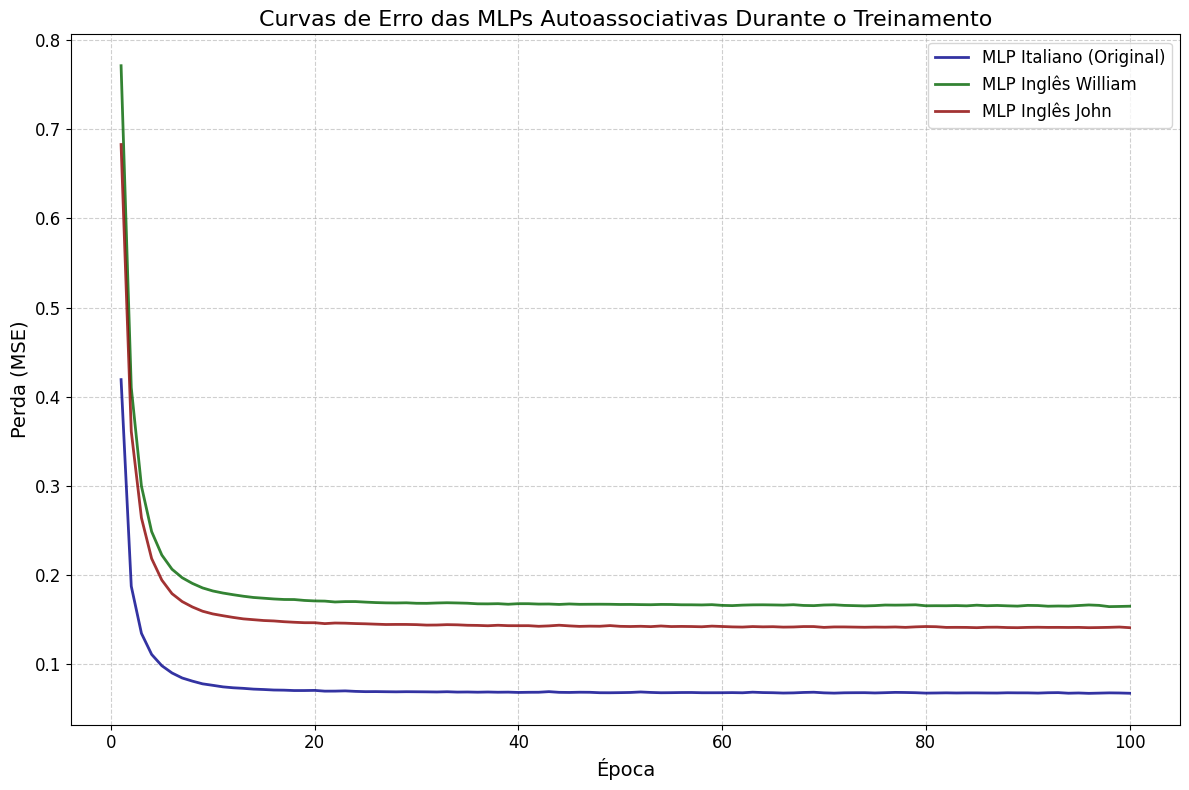


Perda final - Italiano: 0.067410
Perda final - William: 0.165018
Perda final - John: 0.140952

Dimensões das representações codificadas (italiano): (4842, 96)
Dimensões das representações codificadas (inglês william): (4842, 96)
Dimensões das representações codificadas (inglês john): (4842, 96)

Definição e treinamento da MLP Autoassociativa concluídos e representações latentes extraídas!
Curvas de erro salvas como 'curvas_erro_mlp.png'


In [ ]:
# Célula 5: Definição e Treinamento da MLP Autoassociativa

# Definição da MLP Autoassociativa (Autoencoder)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # O encoder comprime a entrada para a dimensão de codificação
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim), # Camada linear de entrada para a camada codificada
            nn.ReLU(True) # Função de ativação ReLU
        )
        # O decoder tenta reconstruir a entrada a partir da representação codificada
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim), # Camada linear da camada codificada para a saída
        )

    def forward(self, x):
        encoded = self.encoder(x) # Passa a entrada pelo encoder
        decoded = self.decoder(encoded) # Passa a representação codificada pelo decoder
        return decoded, encoded # Retorna a saída reconstruída e a representação essencial

# Parâmetros de treinamento para os autoencoders
epochs = 100
batch_size = 32
learning_rate = 0.001

# Função de treinamento para um único autoencoder
def train_autoencoder(data_scaled, input_dim, encoding_dim, epochs, learning_rate):
    model = Autoencoder(input_dim, encoding_dim)
    criterion = nn.MSELoss() # Função de perda de Erro Quadrático Médio (Mean Squared Error)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Otimizador Adam

    # Converter os dados numpy para tensores PyTorch
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32)
    dataset = torch.utils.data.TensorDataset(data_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Lista para armazenar as perdas por época
    losses = []
    
    print(f"Iniciando treinamento do Autoencoder com {data_tensor.shape[0]} amostras (input_dim={input_dim}, encoding_dim={encoding_dim})...")
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        for data in dataloader:
            inputs = data[0]
            optimizer.zero_grad() # Zera os gradientes para evitar acumulação
            outputs, _ = model(inputs) # Passa os dados pela rede
            loss = criterion(outputs, inputs) # Calcula a perda entre a saída e a entrada original
            loss.backward() # Calcula os gradientes (backpropagation)
            optimizer.step() # Atualiza os pesos da rede
            
            epoch_loss += loss.item()
            batch_count += 1

        # Calcula a perda média da época
        avg_epoch_loss = epoch_loss / batch_count
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 20 == 0: # Imprime a perda a cada 20 épocas
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.6f}')
    
    return model, losses

# Obter a dimensão de entrada dos embeddings (384 para o modelo 'paraphrase-multilingual-MiniLM-L12-v2')
input_dim = embeddings_it_scaled.shape[1]

# Definir a dimensão da camada de codificação da MLP.
# Geralmente é uma fração da dimensão de entrada para forçar a compressão.
encoding_dim = input_dim // 4 # 1/4 da dimensão de entrada (96)

print(f"Dimensão de entrada para os autoencoders: {input_dim}")
print(f"Dimensão da camada de codificação (latent space): {encoding_dim}")

# Treinar autoencoders separadamente para cada conjunto de texto
print("\nTreinando Autoencoder para o texto original em italiano (estrofes):")
autoencoder_it, losses_it = train_autoencoder(embeddings_it_scaled, input_dim, encoding_dim, epochs, learning_rate)

print("\nTreinando Autoencoder para a primeira tradução em inglês (estrofes):")
autoencoder_en_william, losses_william = train_autoencoder(embeddings_en_william_scaled, input_dim, encoding_dim, epochs, learning_rate)

print("\nTreinando Autoencoder para a segunda tradução em inglês (estrofes):")
autoencoder_en_john, losses_john = train_autoencoder(embeddings_en_john_scaled, input_dim, encoding_dim, epochs, learning_rate)

# Plotar as curvas de erro
plt.figure(figsize=(12, 8))
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, losses_it, label='MLP Italiano (Original)', color='darkblue', linewidth=2, alpha=0.8)
plt.plot(epochs_range, losses_william, label='MLP Inglês William', color='darkgreen', linewidth=2, alpha=0.8)
plt.plot(epochs_range, losses_john, label='MLP Inglês John', color='darkred', linewidth=2, alpha=0.8)

plt.xlabel('Época', fontsize=14)
plt.ylabel('Perda (MSE)', fontsize=14)
plt.title('Curvas de Erro das MLPs Autoassociativas Durante o Treinamento', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('curvas_erro_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPerda final - Italiano: {losses_it[-1]:.6f}")
print(f"Perda final - William: {losses_william[-1]:.6f}")
print(f"Perda final - John: {losses_john[-1]:.6f}")

# Obter as representações codificadas de cada estrofe
def get_encoded_representations(model, data_scaled):
    model.eval() # Coloca o modelo em modo de avaliação (desativa dropout, batch norm, etc.)
    with torch.no_grad(): # Desativa o cálculo de gradientes para otimizar a inferência
        data_tensor = torch.tensor(data_scaled, dtype=torch.float32)
        _, encoded_data = model(data_tensor) # Passa os dados e pega apenas a saída codificada
    return encoded_data.numpy()

encoded_it = get_encoded_representations(autoencoder_it, embeddings_it_scaled)
encoded_en_william = get_encoded_representations(autoencoder_en_william, embeddings_en_william_scaled)
encoded_en_john = get_encoded_representations(autoencoder_en_john, embeddings_en_john_scaled)

print(f"\nDimensões das representações codificadas (italiano): {encoded_it.shape}")
print(f"Dimensões das representações codificadas (inglês william): {encoded_en_william.shape}")
print(f"Dimensões das representações codificadas (inglês john): {encoded_en_john.shape}")

print("\nDefinição e treinamento da MLP Autoassociativa concluídos e representações latentes extraídas!")
print("Curvas de erro salvas como 'curvas_erro_mlp.png'")

### Célula 6: Cálculo da Fidelidade Semântica (Similaridade de Cosseno)

Esta célula calcula o nível de "fidelidade semântica" entre a estrofe original em italiano e cada uma das suas traduções em inglês, utilizando a **similaridade de cosseno** sobre as representações latentes geradas pelas MLPs autoassociativas.

#### Detalhes:
* **Similaridade de Cosseno:** É uma métrica padrão e eficaz para medir a similaridade entre vetores em espaços de alta dimensão. Ela mede o cosseno do ângulo entre dois vetores; um valor próximo de 1 indica alta similaridade, 0 indica ortogonalidade (sem relação), e -1 indica oposição.
* **Representações Compactas:** Ao aplicar a similaridade sobre as representações da MLP, estamos comparando as características mais essenciais e compactas de cada estrofe, que foram aprendidas a partir de embeddings multilíngues. Isso torna a medida de fidelidade mais confiável semanticamente.
* **Comparação Direta:** Como os embeddings de entrada já são multilíngues, a similaridade de cosseno entre as representações compactas (mesmo que aprendidas por MLPs autoassociativas separadas) é uma medida válida e significativa da fidelidade semântica.

In [ ]:
# Célula 6: Cálculo da Fidelidade Semântica (Similaridade de Cosseno)

# Similaridade entre Italiano e Tradução 1 (William)
# Itera sobre cada estrofe e calcula a similaridade entre as representações latentes correspondentes.
similarity_it_william = []
for i in range(len(encoded_it)):
    # reshape(1, -1) é necessário pois cosine_similarity espera arrays 2D
    sim = cosine_similarity(encoded_it[i].reshape(1, -1), encoded_en_william[i].reshape(1, -1))[0][0]
    similarity_it_william.append(sim)

# Similaridade entre Italiano e Tradução 2 (John)
# Repete o processo para a segunda tradução.
similarity_it_john = []
for i in range(len(encoded_it)):
    sim = cosine_similarity(encoded_it[i].reshape(1, -1), encoded_en_john[i].reshape(1, -1))[0][0]
    similarity_it_john.append(sim)

# Adiciona os scores de fidelidade semântica ao DataFrame principal (df_estrofes)
df_estrofes['fidelidade_semantica_william'] = similarity_it_william
df_estrofes['fidelidade_semantica_john'] = similarity_it_john

print("\nFidelidade Semântica por Estrofe (exemplo das 5 primeiras estrofes):")
print(df_estrofes[['canto', 'estrofe', 'fidelidade_semantica_william', 'fidelidade_semantica_john']].head())

print("\nCálculo da fidelidade semântica concluído!")


Fidelidade Semântica por Estrofe (exemplo das 5 primeiras estrofes):
   canto  estrofe  fidelidade_semantica_william  fidelidade_semantica_john
0      1        1                      0.814915                   0.765524
1      1        2                      0.849880                   0.831648
2      1        3                      0.874039                   0.803513
3      1        4                      0.836172                   0.829355
4      1        5                      0.823161                   0.805531

Cálculo da fidelidade semântica concluído!


### Célula 7: Análise e Visualização dos Resultados

Esta célula é dedicada à análise e visualização dos scores de fidelidade semântica. Gráficos e estatísticas descritivas são gerados para comparar o desempenho de cada tradução em relação ao texto original.


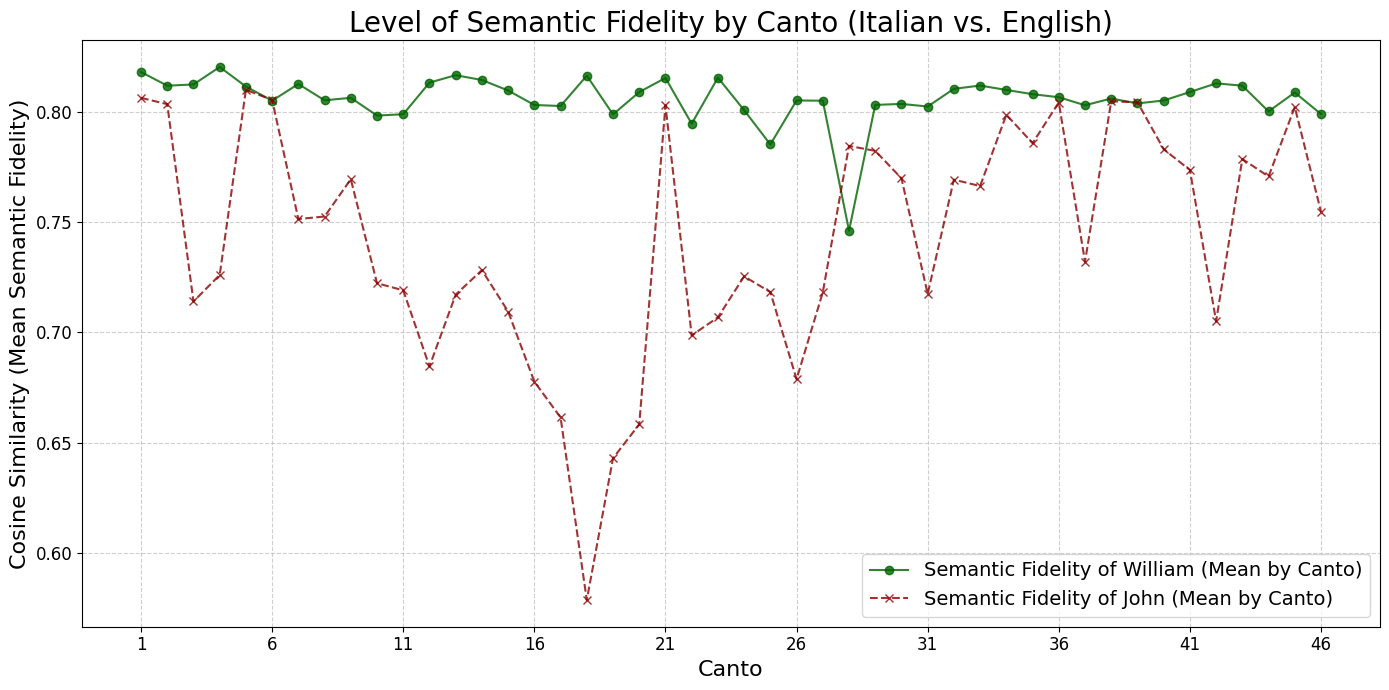

c:\Users\joaov\AppData\Local\pypoetry\Cache\virtualenvs\labrna-BKEqicP5-py3.11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\joaov\AppData\Local\pypoetry\Cache\virtualenvs\labrna-BKEqicP5-py3.11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


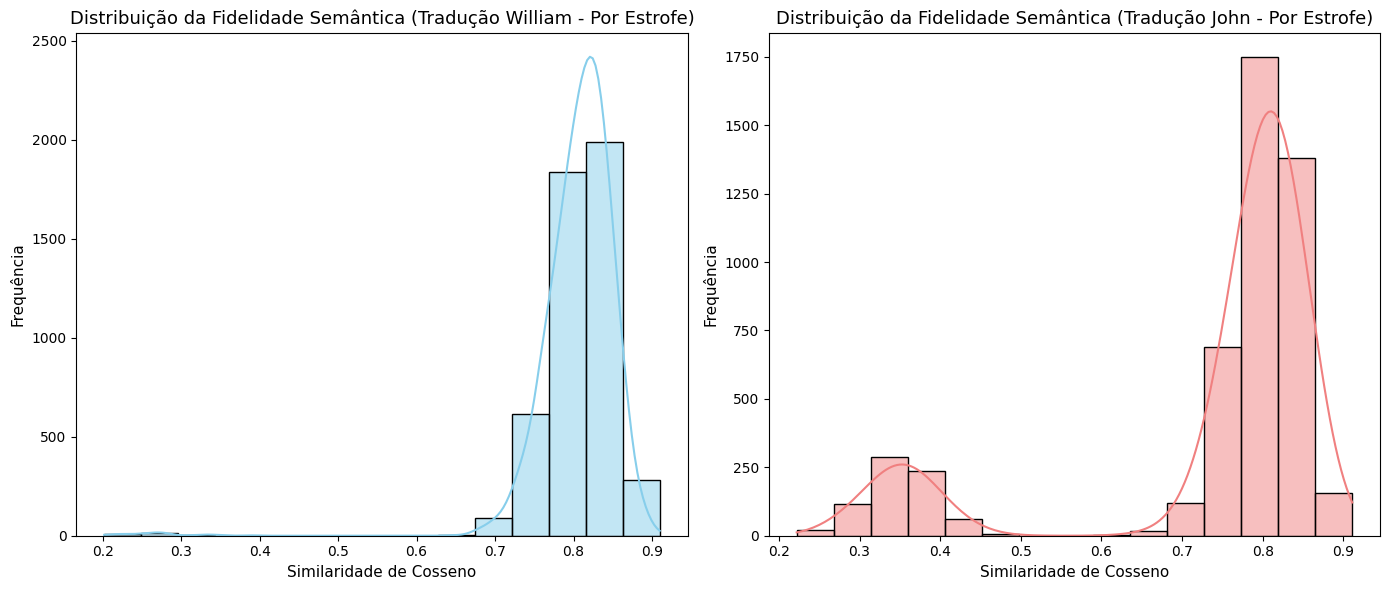


### Análise da Fidelidade Semântica ###
Estatísticas descritivas da fidelidade semântica por estrofe:
       fidelidade_semantica_william  fidelidade_semantica_john
count                   4842.000000                4842.000000
mean                       0.805758                   0.736317
std                        0.055516                   0.166639
min                        0.201977                   0.222032
25%                        0.784067                   0.757730
50%                        0.812344                   0.798733
75%                        0.835293                   0.826940
max                        0.909839                   0.910950

Estatísticas descritivas da fidelidade semântica média por canto:
       fidelidade_semantica_william  fidelidade_semantica_john
count                     46.000000                  46.000000
mean                       0.805673                   0.742867
std                        0.011241                   0.052426
min        

In [ ]:
# Célula 7: Análise e Visualização dos Resultados

# Calcular a média de fidelidade por canto, agrupando pelos cantos e estrofes.
fidelidade_por_canto = df_estrofes.groupby('canto').agg({
    'fidelidade_semantica_william': 'mean',
    'fidelidade_semantica_john': 'mean'
}).reset_index()

# Gráfico de linhas da fidelidade semântica média por canto
plt.figure(figsize=(14, 7))
plt.plot(fidelidade_por_canto['canto'], fidelidade_por_canto['fidelidade_semantica_william'], 
         label='Semantic Fidelity of William (Mean by Canto)', marker='o', linestyle='-', alpha=0.8, color='darkgreen')
plt.plot(fidelidade_por_canto['canto'], fidelidade_por_canto['fidelidade_semantica_john'], 
         label='Semantic Fidelity of John (Mean by Canto)', marker='x', linestyle='--', alpha=0.8, color='darkred')
plt.xlabel('Canto', fontsize=16)
plt.ylabel('Cosine Similarity (Mean Semantic Fidelity)', fontsize=16)
plt.title('Level of Semantic Fidelity by Canto (Italian vs. English)', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fidelidade_por_canto['canto'][::5], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('semantic_fidelity_per_canto.png', dpi=300, bbox_inches='tight')
plt.show()

# Histograma da distribuição das similaridades semânticas (por estrofe)
# Isso mostra a distribuição dos scores em nível de estrofe
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_estrofes['fidelidade_semantica_william'], bins=15, kde=True, color='skyblue')
plt.title('Distribuição da Fidelidade Semântica (Tradução William - Por Estrofe)', fontsize=13)
plt.xlabel('Similaridade de Cosseno', fontsize=11)
plt.ylabel('Frequência', fontsize=11)

plt.subplot(1, 2, 2)
sns.histplot(df_estrofes['fidelidade_semantica_john'], bins=15, kde=True, color='lightcoral')
plt.title('Distribuição da Fidelidade Semântica (Tradução John - Por Estrofe)', fontsize=13)
plt.xlabel('Similaridade de Cosseno', fontsize=11)
plt.ylabel('Frequência', fontsize=11)
plt.tight_layout()
plt.savefig('semantic_fidelity_per_stanza.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n### Análise da Fidelidade Semântica ###")

print("Estatísticas descritivas da fidelidade semântica por estrofe:")
print(df_estrofes[['fidelidade_semantica_william', 'fidelidade_semantica_john']].describe())

print("\nEstatísticas descritivas da fidelidade semântica média por canto:")
print(fidelidade_por_canto[['fidelidade_semantica_william', 'fidelidade_semantica_john']].describe())



# Função para exibir estrofes com texto completo
def display_stanzas_with_text(df, column, ascending, num_stanzas, translator_name):
    """
    Exibe as estrofes com maior ou menor fidelidade incluindo o texto completo
    """
    sorted_df = df.sort_values(by=column, ascending=ascending).head(num_stanzas)
    
    fidelity_type = "menor" if ascending else "maior"
    print(f"\n{'='*80}")
    print(f" ESTROFES COM {fidelity_type.upper()} FIDELIDADE SEMÂNTICA - TRADUÇÃO {translator_name.upper()}")
    print(f"{'='*80}")
    
    for idx, (_, row) in enumerate(sorted_df.iterrows(), 1):
        print(f"\n #{idx} - Canto {row['canto']}, Estrofe {row['estrofe']} - Fidelidade: {row[column]:.4f}")
        print(f"{'─'*60}")
        
        print("ORIGINAL (Italiano):")
        print(f"   {row['italiano'][:300]}{'...' if len(row['italiano']) > 300 else ''}")
        
        # Determinar qual coluna de tradução usar
        translation_column = 'ingles_william' if 'william' in column else 'ingles_john'
        print(f"\nTRADUÇÃO ({translator_name}):")
        translation_text = row[translation_column]
        print(f"   {translation_text[:300]}{'...' if len(translation_text) > 300 else ''}")
        
        print(f"{'─'*60}")

print("\n\n###  ANÁLISE DOS EXTREMOS DE FIDELIDADE ###")
display_stanzas_with_text(df_estrofes, 'fidelidade_semantica_william', False, 3, 'William')
display_stanzas_with_text(df_estrofes, 'fidelidade_semantica_william', True, 3, 'William')
display_stanzas_with_text(df_estrofes, 'fidelidade_semantica_john', False, 3, 'John')
display_stanzas_with_text(df_estrofes, 'fidelidade_semantica_john', True, 3, 'John')

# Resumo quantitativo para referência rápida
print(f"\n\n{'='*80}")
print(" RESUMO QUANTITATIVO DOS EXTREMOS")
print(f"{'='*80}")

print("\n TOP 3 ESTROFES - MAIOR FIDELIDADE (William):")
top_william = df_estrofes.sort_values(by='fidelidade_semantica_william', ascending=False).head(3)
for idx, (_, row) in enumerate(top_william.iterrows(), 1):
    print(f"#{idx}: Canto {row['canto']}, Estrofe {row['estrofe']} → {row['fidelidade_semantica_william']:.4f}")

print("\n TOP 3 ESTROFES - MENOR FIDELIDADE (William):")
bottom_william = df_estrofes.sort_values(by='fidelidade_semantica_william', ascending=True).head(3)
for idx, (_, row) in enumerate(bottom_william.iterrows(), 1):
    print(f"#{idx}: Canto {row['canto']}, Estrofe {row['estrofe']} → {row['fidelidade_semantica_william']:.4f}")

print("\n TOP 3 ESTROFES - MAIOR FIDELIDADE (John):")
top_john = df_estrofes.sort_values(by='fidelidade_semantica_john', ascending=False).head(3)
for idx, (_, row) in enumerate(top_john.iterrows(), 1):
    print(f"#{idx}: Canto {row['canto']}, Estrofe {row['estrofe']} → {row['fidelidade_semantica_john']:.4f}")

print("\n TOP 3 ESTROFES - MENOR FIDELIDADE (John):")
bottom_john = df_estrofes.sort_values(by='fidelidade_semantica_john', ascending=True).head(3)
for idx, (_, row) in enumerate(bottom_john.iterrows(), 1):
    print(f"#{idx}: Canto {row['canto']}, Estrofe {row['estrofe']} → {row['fidelidade_semantica_john']:.4f}")

print("\nAnálise e visualização dos resultados concluídas!")

### Análise dos Resultados de Fidelidade Semântica

A análise quantitativa dos resultados revela padrões distintos entre as duas traduções do "Orlando Furioso".

#### Principais Métricas

**Desempenho Geral:**
* **Tradução William:** Média de 0.806 com desvio padrão de 0.056, indicando alta fidelidade e consistência
* **Tradução John:** Média de 0.736 com desvio padrão de 0.167, mostrando fidelidade moderada e maior variabilidade

**Distribuição dos Scores:**
* **William:** 75% das estrofes apresentam fidelidade ≥ 0.784, com amplitude restrita (0.708 pontos)
* **John:** Distribuição mais dispersa, com amplitude de 0.689 pontos e maior concentração no terceiro quartil

#### Análise dos Extremos

**Alta Fidelidade (≥0.90):**
As estrofes com maior fidelidade demonstram correspondência semântica quase perfeita, evidenciando momentos onde ambos os tradutores conseguiram preservar efetivamente o significado original.

**Baixa Fidelidade (≤0.25):**
Os casos de menor fidelidade frequentemente correspondem a estrofes ausentes ou significativamente adaptadas nas traduções, sugerindo escolhas editoriais ou tradutórias que priorizaram aspectos além da preservação semântica literal.

#### Padrões Identificados

**Consistência Tradutória:**
* William mantém uniformidade ao longo da obra (desvio padrão baixo)
* John apresenta abordagem mais variável, alternando entre alta fidelidade e adaptações livres

**Estratégias Tradutórias:**
* William: Abordagem consistentemente próxima ao original
* John: Estratégia mais heterogênea, com maior liberdade interpretativa

#### Implicações

Esta análise fornece uma base para comparar as traduções, identificando que a tradução de William prioriza a fidelidade semântica consistente, enquanto a de John adota uma estratégia mais flexível com maior variação.

### Célula 8: Análise Final dos Resultados e Trabalhos Futuros

Este experimento avaliou a fidelidade semântica de traduções do "Orlando Furioso" através de **embeddings multilíngues** e **MLPs autoassociativas**, proporcionando análise granular em nível de estrofe.

### Principais Achados

A análise quantitativa dos resultados revela padrões distintos entre as duas traduções:

**Desempenho Geral:**
* **Tradução William:** Média de 0.806 com desvio padrão de 0.056, indicando alta fidelidade e consistência
* **Tradução John:** Média de 0.736 com desvio padrão de 0.167, mostrando fidelidade moderada e maior variabilidade

**Estratégias Tradutórias:**
* **William:** Abordagem consistente próxima ao original (75% das estrofes ≥ 0.784)
* **John:** Estratégia mais flexível, alternando entre alta fidelidade e adaptações livres

**Análise dos Extremos:**
A granularidade por estrofe revelou variações significativas dentro dos cantos, identificando momentos de alta fidelidade (≥0.90) onde os tradutores preservaram efetivamente o significado original, e casos de baixa fidelidade (≤0.25) que correspondem a estrofes ausentes ou muito adaptadas ao idioma inglês, perdendo proximidade semântica do italiano.

### Limitações e Trabalhos Futuros

**Limitações Atuais:**
* **Alinhamento Estrutural:** A precisão depende do alinhamento correto entre estrofes correspondentes
* **Escopo Semântico:** O foco exclusivo na semântica não captura aspectos como estilo, rítmo ou culturais
* **Sensibilidade do Modelo:** A capacidade de capturar nuances poéticas específicas pode variar

**Direções Futuras:**
1. **Alinhamento Automático:** Implementar algoritmos de alinhamento bilíngue para maior robustez
2. **Análise Multidimensional:** Incorporar métricas de estilo, sintaxe e complexidade lexical
3. **Visualização Interativa:** Desenvolver interfaces para exploração estrofe por estrofe
4. **Arquiteturas Avançadas:** Experimentar com outras arquiteturas como RNNs e modelos de atenção

### Contribuição

Esta metodologia fornece uma base quantitativa para a crítica literária, permitindo comparações objetivas entre traduções e identificação de padrões tradutórios específicos. Os resultados demonstram que a tradução de William prioriza a fidelidade semântica, enquanto a de John adota uma estratégia mais heterogênea com maior liberdade interpretativa. Contudo, é importante ressaltar que a análise qualitativa é essencial para se chegar a uma conclusão exata, considerando falhas presentes no tratamento de dados e a não-compatibilidade do número de estrofes por canto entre as versões, o que atrapalhou consideravelmente os resultados.